## **`4. ▶ Feature Extraction and Model Training`**

* This notebook outlines the process of feature extraction and model training for classifying palestine news  as real or fake.
* The dataset used is 'cleaned_news_v2.csv', containing preprocessed text, platform information, numerical features, and labels (fake = 0, real = 1).

#### **Objectives**

* Extract features using TF-IDF, Word2Vec (CBOW), and Word2Vec (Skip-gram).
  - We are trying to use AraBert, but it takes time and resources.

* Train and evaluate multiple machine learning models: Logistic Regression, SVM, Naive Bayes, Random Forest, and XGBoost.

* Compare model performance across different feature sets.

#### **Dataset**
* Source: cleaned_news_v2.csv
* Columns Used:
    * clean_text: Preprocessed news text.
    * platform: Source platform (e.g., الجزيرة, تويتر).
    * Numerical features: has_emoji, has_number, has_punctuation, has_hashtag, has_link, char_count, word_count.
    * Label: Target variable (fake = 0, real = 1).

#### **Adding New Features**

In [ ]:
def count_emojis(text):
    return sum(1 for c in text if emoji.is_emoji(c))

def count_numbers(text):
    return len(re.findall(r'\d', text))

def count_punctuation(text):
    return len(re.findall(r'[!()-\[\]{};:\'",<>./?@#$%^&*_~`÷×؛؟،]', text))

def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def count_links(text):
    return len(re.findall(r'https?://\S+|www\.\S+', text))

def count_chars(text):
    return len(text.replace(' ', ''))

def count_words(text):
    return len(text.split())


real_fake_news['combined_text'] = real_fake_news['title'].fillna('') + ' ' + real_fake_news['News content'].fillna('')

real_fake_news['has_emoji'] = real_fake_news['combined_text'].astype(str).apply(count_emojis)
real_fake_news['has_number'] = real_fake_news['combined_text'].astype(str).apply(count_numbers)
real_fake_news['has_punctuation'] = real_fake_news['combined_text'].astype(str).apply(count_punctuation)
real_fake_news['has_hashtag'] = real_fake_news['combined_text'].astype(str).apply(count_hashtags)
real_fake_news['has_link'] = real_fake_news['combined_text'].astype(str).apply(count_links)
real_fake_news['char_count'] = real_fake_news['combined_text'].astype(str).apply(count_chars)
real_fake_news['word_count'] = real_fake_news['combined_text'].astype(str).apply(count_words)

real_fake_news.to_csv('/content/drive/MyDrive/cleaned_news_v2.csv', index=False)

#### **Data Loading**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cleaned_news_v2.csv')

# Convert platform names to Arabic
convert_eng_arb = {
    'Aljazeera': 'الجزيرة',
    'Misbar': 'مسبار',
    'Tibyan': 'تبيان',
    'Twitter': 'تويتر',
    'Reuters': 'رويترز',
    'AFP': 'فرانس برس',
    'Facebook': 'فيسبوك',
    'YouTube': 'يوتيوب',
    'Instagram': 'انستاغرام',
    'TikTok': 'تيك توك',
    'tayqan': 'تيقن',
    'chayyek': 'شييك'
}
df['platform'] = df['platform'].map(convert_eng_arb).fillna(df['platform'])

# Define numerical feature columns
num_features_cols = ['has_emoji', 'has_number', 'has_punctuation', 'has_hashtag', 'has_link', 'char_count', 'word_count']

### **2. Feature Extraction and Model Training**

##### 2.1 TF-IDF on Text Only

Extract features using TF-IDF on the clean_text column and evaluate models.

In [ ]:
texts = df['clean_text'].astype(str).values
labels = df['Label'].map({'fake': 0, 'real': 1}).values

# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = tfidf.fit_transform(texts)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate
print('TF-IDF on Text Only Results')
for name, model in models.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

TF-IDF on Text Only Results

----------- Logistic Regression -----------
Accuracy: 0.8822
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       288
           1       0.90      0.94      0.92       782

    accuracy                           0.88      1070
   macro avg       0.86      0.83      0.85      1070
weighted avg       0.88      0.88      0.88      1070


----------- SVM -----------
Accuracy: 0.9028
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       288
           1       0.94      0.93      0.93       782

    accuracy                           0.90      1070
   macro avg       0.87      0.88      0.88      1070
weighted avg       0.90      0.90      0.90      1070


----------- Naive Bayes -----------
Accuracy: 0.8729
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       288
           1       0.90      0.93      0.91    

##### 2.2 TF-IDF on Text and Platform

Combine TF-IDF features with one-hot encoded platform features.

In [ ]:
texts = df['clean_text'].astype(str).values
platforms = df[['platform']].astype(str).values
labels = df['Label'].map({'fake': 0, 'real': 1}).values

# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_text = tfidf.fit_transform(texts)

# One-hot encoding for platform
encoder = OneHotEncoder(sparse_output=True)
X_platform = encoder.fit_transform(platforms)

# Combine features
X = hstack([X_text, X_platform])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train and evaluate
print('TF-IDF on Text and Platform Results')
for name, model in models.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

TF-IDF on Text and Platform Results

----------- Logistic Regression -----------
Accuracy: 0.9411
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       300
           1       0.98      0.94      0.96       770

    accuracy                           0.94      1070
   macro avg       0.92      0.94      0.93      1070
weighted avg       0.94      0.94      0.94      1070


----------- SVM -----------
Accuracy: 0.9430
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       300
           1       0.97      0.95      0.96       770

    accuracy                           0.94      1070
   macro avg       0.93      0.94      0.93      1070
weighted avg       0.94      0.94      0.94      1070


----------- Naive Bayes -----------
Accuracy: 0.9252
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       300
           1       0.98      0.92      

##### 2.3 TF-IDF on Text, Platform, and Numerical Features

Incorporate numerical features with TF-IDF and platform features.

In [ ]:
X_num = df[num_features_cols].fillna(0).values
X_num_sparse = csr_matrix(X_num)

# Combine features
X = hstack([X_text, X_platform, X_num_sparse])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train and evaluate (excluding SVM) Because it takes a long time and is suitable for small data.
models_no_svm = {k: v for k, v in models.items() if k != 'SVM'}
print('TF-IDF on Text, Platform, and Numerical Features Results')
for name, model in models_no_svm.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

TF-IDF on Text, Platform, and Numerical Features Results

----------- Logistic Regression -----------
Accuracy: 0.9290
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.94      0.92      1070
weighted avg       0.94      0.93      0.93      1070


----------- Naive Bayes -----------
Accuracy: 0.9234
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       300
           1       0.96      0.93      0.95       770

    accuracy                           0.92      1070
   macro avg       0.90      0.92      0.91      1070
weighted avg       0.93      0.92      0.92      1070


----------- Random Forest -----------
Accuracy: 0.9421
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       300
        

##### 2.4 Word2Vec (CBOW) on Text Only

Use Word2Vec CBOW to generate text embeddings

In [ ]:
tokenized_texts = [word_tokenize(text) for text in texts]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, sg=0, workers=4, seed=42)

def get_avg_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

X_vectors = np.array([get_avg_vector(tokens, w2v_model, 100) for tokens in tokenized_texts])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vectors, labels, test_size=0.2, random_state=42, stratify=labels)

# Train and evaluate (use GaussianNB)
models_w2v = models.copy()
models_w2v['Naive Bayes'] = GaussianNB()
print('Word2Vec (CBOW) on Text Only Results')
for name, model in models_w2v.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (CBOW) on Text Only Results

----------- Logistic Regression -----------
Accuracy: 0.8327
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       288
           1       0.85      0.93      0.89       782

    accuracy                           0.83      1070
   macro avg       0.80      0.75      0.77      1070
weighted avg       0.83      0.83      0.82      1070


----------- SVM -----------
Accuracy: 0.8439
              precision    recall  f1-score   support

           0       0.77      0.60      0.67       288
           1       0.86      0.93      0.90       782

    accuracy                           0.84      1070
   macro avg       0.82      0.77      0.79      1070
weighted avg       0.84      0.84      0.84      1070


----------- Naive Bayes -----------
Accuracy: 0.8364
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       288
           1       0.91      0.86     

##### 2.5 Word2Vec (CBOW) on Text and Platform

Combine Word2Vec embeddings with platform features.

In [ ]:
X_text_vec = np.array([get_avg_vector(doc, w2v_model, 100) for doc in tokenized_texts])
X_text_sparse = csr_matrix(X_text_vec)
X = hstack([X_text_sparse, X_platform])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train and evaluate (exclude MultinomialNB)
models_no_nb = {k: v for k, v in models.items() if k != 'Naive Bayes'}
print('Word2Vec (CBOW) on Text and Platform Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (CBOW) on Text and Platform Results

----------- Logistic Regression -----------
Accuracy: 0.9262
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.93      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- SVM -----------
Accuracy: 0.9234
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       300
           1       1.00      0.89      0.94       770

    accuracy                           0.92      1070
   macro avg       0.89      0.95      0.91      1070
weighted avg       0.94      0.92      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9224
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       300
           1       0.96     

##### 2.6 Word2Vec (CBOW) on Text, Platform, and Numerical Features

Incorporate numerical features with Word2Vec and platform features.

In [ ]:
X = hstack([X_text_sparse, X_platform, X_num_sparse])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }


# Train and evaluate
print('Word2Vec (CBOW) on Text, Platform, and Numerical Features Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (CBOW) on Text, Platform, and Numerical Features Results

----------- Logistic Regression -----------
Accuracy: 0.9262
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       300
           1       0.97      0.93      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.93      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9271
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       300
           1       0.96      0.94      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.92      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- XGBoost -----------
Accuracy: 0.9215
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       300
   

##### 2.7 Word2Vec (Skip-gram) on Text Only

Use Word2Vec Skip-gram to generate text embeddings.

In [ ]:
# Train Word2Vec Skip-gram model (sg=1 for Skip-gram)
w2v_skipgram_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, sg=1, workers=4, seed=42)

# Use same function to compute average vector
X_vectors = np.array([get_avg_vector(tokens, w2v_skipgram_model, 100) for tokens in tokenized_texts])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vectors, labels, test_size=0.2, random_state=42, stratify=labels)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }
# Train and evaluate (use GaussianNB for continuous features)
print('Word2Vec (Skip-gram) on Text Only Results')
for name, model in models_w2v.items():
    print(f'\n----------- {name}----------- ')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (Skip-gram) on Text Only Results

----------- Logistic Regression----------- 
Accuracy: 0.8523
              precision    recall  f1-score   support

           0       0.76      0.66      0.71       288
           1       0.88      0.92      0.90       782

    accuracy                           0.85      1070
   macro avg       0.82      0.79      0.80      1070
weighted avg       0.85      0.85      0.85      1070


----------- SVM----------- 
Accuracy: 0.8598
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       288
           1       0.89      0.93      0.91       782

    accuracy                           0.86      1070
   macro avg       0.83      0.80      0.81      1070
weighted avg       0.86      0.86      0.86      1070


----------- Naive Bayes----------- 
Accuracy: 0.8551
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       288
           1       0.93      0.87

##### 2.8 Word2Vec (Skip-gram) on Text and Platform

Combine Word2Vec Skip-gram embeddings with platform features.

In [ ]:
X_text_vec = np.array([get_avg_vector(doc, w2v_skipgram_model, 100) for doc in tokenized_texts])
X_text_sparse = csr_matrix(X_text_vec)
X = hstack([X_text_sparse, X_platform])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }

# Train and evaluate (exclude MultinomialNB)
print('Word2Vec (Skip-gram) on Text and Platform Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (Skip-gram) on Text and Platform Results

----------- Logistic Regression -----------
Accuracy: 0.9299
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.93      0.92      1070
weighted avg       0.94      0.93      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9271
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       300
           1       0.96      0.93      0.95       770

    accuracy                           0.93      1070
   macro avg       0.90      0.92      0.91      1070
weighted avg       0.93      0.93      0.93      1070


----------- XGBoost -----------
Accuracy: 0.9262
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       300
           1       

##### 2.9 Word2Vec (Skip-gram) on Text, Platform, and Numerical Features

Incorporate numerical features with Word2Vec Skip-gram and platform features.

In [ ]:
X = hstack([X_text_sparse, X_platform, X_num_sparse])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

models_no_nb = {k: v for k, v in models.items() if k not in ['Naive Bayes','SVM'] }
# Train and evaluate
print('Word2Vec (Skip-gram) on Text, Platform, and Numerical Features Results')
for name, model in models_no_nb.items():
    print(f'\n----------- {name} -----------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Word2Vec (Skip-gram) on Text, Platform, and Numerical Features Results

----------- Logistic Regression -----------
Accuracy: 0.9318
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       300
           1       0.98      0.92      0.95       770

    accuracy                           0.93      1070
   macro avg       0.91      0.94      0.92      1070
weighted avg       0.94      0.93      0.93      1070


----------- Random Forest -----------
Accuracy: 0.9308
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       300
           1       0.97      0.94      0.95       770

    accuracy                           0.93      1070
   macro avg       0.91      0.93      0.92      1070
weighted avg       0.93      0.93      0.93      1070


----------- XGBoost -----------
Accuracy: 0.9336
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       30

##### 2.10 AraBERT with Text, Platform, and Numerical Features

Use AraBERT embeddings for text, combined with platform and numerical features.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv2")

def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()


# Map Arabic platform names
df['platform'] = df['platform'].map(convert_eng_arb).fillna(df['platform'])

# Extract text, platform, and labels
texts = df['clean_text'].astype(str).tolist()
platforms = df[['platform']].astype(str).values
labels = df['Label'].map({'fake': 0, 'real': 1}).values

# Get BERT embeddings for all texts
X_text = np.array([get_bert_embedding(text) for text in texts])

# One-Hot Encoding for platform
encoder = OneHotEncoder(handle_unknown='ignore')
X_platform = encoder.fit_transform(platforms).toarray()

# Select numerical features
num_features_cols = ['has_emoji', 'has_number', 'has_punctuation', 'has_hashtag',
                     'has_link', 'char_count', 'word_count']
X_num = df[num_features_cols].fillna(0).values

# Combine all features (BERT + platform + numerical)
X = np.hstack([X_text, X_platform, X_num])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)


# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n------------- {name} -------------")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

#### its take more than 1 Hour so i save a screenshot of result

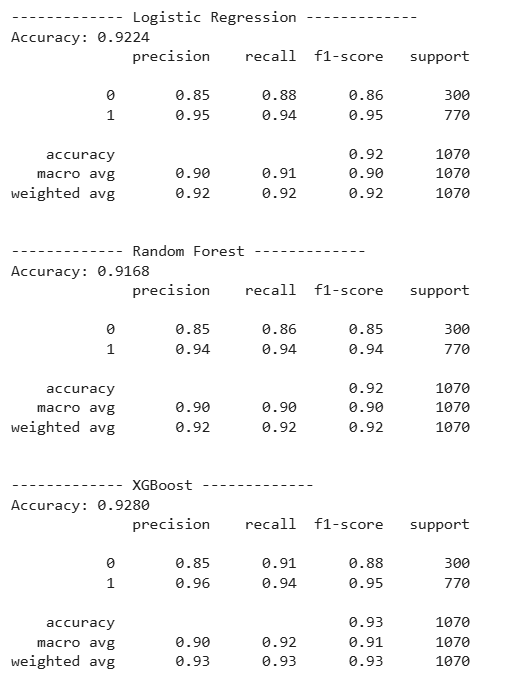

## **`5. ▶ Results Summary`**
### Performance Comparison Table
| Feature Set                              | Best Model              | Accuracy | F1-Score (Fake) | F1-Score (Real) |
|------------------------------------------|--------------------|----------|-----------------|-----------------|
| TF-IDF (Text Only)                      | XGBoost            | 92.06%   | 0.85            | 0.95            |
| TF-IDF (Text + Platform)                | XGBoost            | 95.05%   | 0.91            | 0.97            |
| TF-IDF (Text + Platform + Numerical)    | XGBoost            | 95.05%   | 0.91            | 0.97            |
| Word2Vec CBOW (Text Only)               | XGBoost            | 87.76%   | 0.77            | 0.92            |
| Word2Vec CBOW (Text + Platform)               | XGBoost, Logistic Regression            | 92.62%   | 0.88            | 0.95            |
| Word2Vec CBOW (Text + Platform + Numerical)               | Logistic Regression            | 92.62%   | 0.88            | 0.95            |
| Word2Vec Skip-gram (Text Only)          | XGBoost            | 89.16%    | 0.80           | 0.93           |
| Word2Vec Skip-gram (Text + Platform)          | Logistic Regression            | 92.99%    | 0.88           | 0.95           |
| Word2Vec Skip-gram (Text + Platform + Numerical)          | XGBoost            | 93.36%    | 0.89           | 0.95           |
| AraBERT (Text + Platform + Numerical)          | XGBoost            | 92.80%    | 0.88           | 0.95           |

## **`6.  ▶ Try to Predict the new news`**

#### **Sample 1** : The link of news  [ here ](https://www.misbar.com/factcheck/2025/05/29/%D9%81%D9%8A%D8%AF%D9%8A%D9%88-%D8%AA%D8%B2%D9%8A%D9%8A%D9%86-%D8%A7%D9%84%D9%82%D8%B5%D8%B1-%D8%A7%D9%84%D8%B1%D8%A6%D8%A7%D8%B3%D9%8A-%D9%81%D9%8A-%D8%A5%D9%86%D8%AF%D9%88%D9%86%D9%8A%D8%B3%D9%8A%D8%A7-%D8%A8%D8%B9%D9%84%D9%85-%D9%81%D9%84%D8%B3%D8%B7%D9%8A%D9%86-%D9%85%D9%88%D9%84%D9%91%D9%8E%D8%AF-%D8%A8%D8%A7%D9%84%D8%B0%D9%83%D8%A7%D8%A1-%D8%A7%D9%84%D8%A7%D8%B5%D8%B7%D9%86%D8%A7%D8%B9%D9%8A)

In [ ]:
def predict_news(text, platform, model, w2v_model, encoder, num_features_cols, convert_eng_arb):
    # Tokenize the input text
    tokenized_text = word_tokenize(text)

    # Get Word2Vec Skip-gram embedding (average vector)
    def get_avg_vector(tokens, model, vector_size):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

    text_vec = get_avg_vector(tokenized_text, w2v_model, 100)
    text_vec_sparse = csr_matrix(text_vec.reshape(1, -1))

    # One-hot encode the platform
    platform = convert_eng_arb.get(platform, platform)  # Convert platform name if needed
    platform_vec = encoder.transform([[platform]])

    # Numerical features (set to 0 for simplicity, or extract actual features if available)
    num_features = np.zeros(len(num_features_cols))  # Placeholder: assumes zeros for numerical features
    num_features_sparse = csr_matrix(num_features.reshape(1, -1))

    # Combine features
    features = hstack([text_vec_sparse, platform_vec, num_features_sparse])

    # Predict
    prediction = model.predict(features)
    return 'Real' if prediction[0] == 1 else 'Fake'

# Example usage
sample_text = """
فيديو تزيين القصر الرئاسي في إندونيسيا بعلم فلسطين مولَّد بالذكاء الاصطناعي
#شاهد | تزيين قصر "إستانا نيجارا" الرئاسي في إندونيسيا بعلم فلسطيني ضخم، في لفتة رمزية تعبّر عن دعم الشعب الإندونيسي للقضية الفلسطينية
"""
sample_platform = "تويتر"

# Assuming w2v_skipgram_model, encoder, and num_features_cols are defined from training
print(predict_news(sample_text, sample_platform, models['XGBoost'], w2v_skipgram_model, encoder, num_features_cols, convert_eng_arb))

Fake


#### **Sample Test 2** : The link of news  [ here ](https://www.misbar.com/factcheck/2025/03/30/%D8%A7%D9%84%D9%81%D9%8A%D8%AF%D9%8A%D9%88-%D9%84%D9%8A%D8%B3-%D9%84%D9%85%D8%B8%D8%A7%D9%87%D8%B1%D8%A9-%D9%85%D8%B9%D8%A7%D8%B1%D8%B6%D8%A9-%D9%84%D8%AA%D8%B5%D8%AF%D9%8A%D8%B1-%D8%A7%D9%84%D9%86%D9%81%D8%B7-%D8%A7%D9%84%D8%B9%D8%B1%D8%A7%D9%82%D9%8A-%D8%A5%D9%84%D9%89-%D8%A7%D9%84%D8%A3%D8%B1%D8%AF%D9%86-%D8%A8%D8%B9%D8%AF-%D8%A3%D8%B2%D9%85%D8%A9-%D9%85%D8%A8%D8%A7%D8%B1%D8%A7%D8%A9-%D9%81%D9%84%D8%B3%D8%B7%D9%8A%D9%86)

In [ ]:
sample_text = """
الفيديو  لمظاهرة معارضة لتصدير النفط العراقي إلى الأردن بعد أزمة مباراة فلسطين
الجنوب العراقي يشتعل غضباً ويزحف على الحقول النفطية، عازماً على منع تصدير النفط إلى الأردن اللوطية .
"""
sample_platform = "تويتر"

# Assuming w2v_skipgram_model, encoder, and num_features_cols are defined from training
print(predict_news(sample_text, sample_platform, models['XGBoost'], w2v_skipgram_model, encoder, num_features_cols, convert_eng_arb))

Fake


#### **Sample Test 3** :The link of news  [ here ](https://www.aljazeera.net/news/liveblog/2025/7/14/%D8%A7%D9%84%D8%AD%D8%B1%D8%A8-%D8%B9%D9%84%D9%89-%D8%BA%D8%B2%D8%A9-%D9%85%D8%A8%D8%A7%D8%B4%D8%B1-%D8%B9%D8%B4%D8%B1%D8%A7%D8%AA-%D8%A7%D9%84%D8%B4%D9%87%D8%AF%D8%A7%D8%A1-33)

In [ ]:
sample_text = """
مسؤولة إغاثة: وضع مستشفيات قطاع غزة كارثي
المتحدثة باسم الاتحاد الدولي لجمعيات الهلال والصليب الأحمر للجزيرة:

وضع مستشفيات قطاع غزة كارثي.
نقص كبير بعدد سيارات الإسعاف العاملة في غزة.
انعدام الوقود يعني غياب الحياة تماما بغزة.
انعدام الوقود بمستشفيات غزة يعني انعدام فرص الحياة.
فقدنا العديد من موظفينا بسبب القصف على غزة.
"""
sample_platform = "الجزيرة"

# Assuming w2v_skipgram_model, encoder, and num_features_cols are defined from training
print(predict_news(sample_text, sample_platform, models['XGBoost'], w2v_skipgram_model, encoder, num_features_cols, convert_eng_arb))

Real


## **`7.  ▶ Conclusion`**

* #### The XGBoost model with TF-IDF on text, platform, and numerical features achieved the highest accuracy (95.05%).
* #### This combination is recommended for deployment. Future work could explore hyperparameter tuning and advanced embeddings like AraBERT with more computational resources.

## **`8.  ▶ Future Improvements`**
- Experiment with deep learning models like LSTMs or Transformers.
- Incorporate sentiment analysis as an additional feature.
- Collect more diverse data to improve model generalization.

##### ================================*`Thank you !`*=================================
